In [75]:
import data_import
import os
import matplotlib.pyplot as plt
import numpy as np
import pickle

plt.rcParams.update({'font.size': 20})
plt.rc('figure', figsize=(20, 10))

In [76]:
def exec(dt=1e-2, output_dt=1e-1, tf=60*3, vz=3, nh = 10):

    command = f"java -cp target/Zombies-1.0.jar \
                -Ddt={dt} -DoutputDt={output_dt} -Dtf={tf} \
                -Dvz={vz} -Dnh={nh} \
                Main"
    proc = os.popen(command)
    proc.readlines()
    proc.close()
    data = data_import.Data("zombies.txt")
    return data

In [77]:
def rolling_mean(x, w):
    data = []
    for i in range(len(x)):
        upper = int(min(i+w/2, len(x)))
        lower = int(max(i-w/2, 0))
        data.append(np.mean(x[lower:upper]))
    return data

In [78]:
results_c = {}
vz = np.arange(1,6,0.5)
iterations = 3
NH = 140

if os.path.isfile("results_c.pickle"):
    results_c = pickle.load(open("results_c.pickle", "rb"))
else:


    for v in vz:
        res_iterations = {}
        for iteration in range(iterations):
            data = exec(nh=NH, dt=1e-2, output_dt=1,vz=v)
            time = []
            zcount = []
            res = {}
            for t, z, h, data in data:
                time.append(t)
                zcount.append(z)
            res["time"] = time
            res["zcount"] = zcount
            res_iterations[iteration] = res
        results_c[v] = res_iterations
            



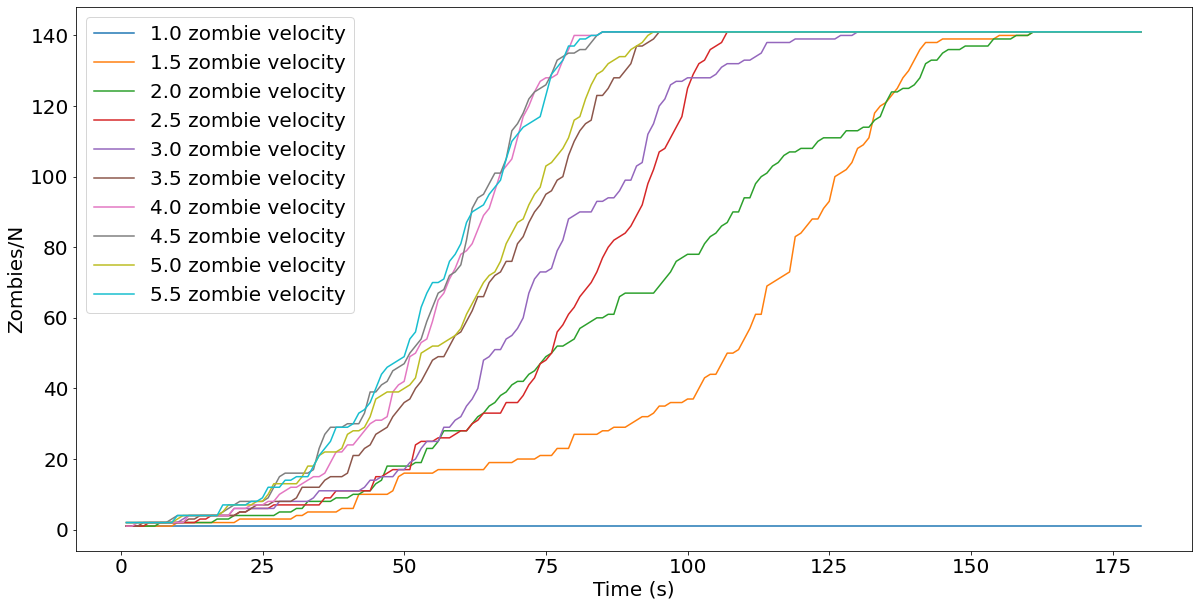

In [79]:
iteration = 2
for v in vz:
    plt.plot(results_c[v][iteration]["time"], np.array(results_c[v][iteration]["zcount"]), label=f"{v} zombie velocity")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Zombies/N")
plt.show()

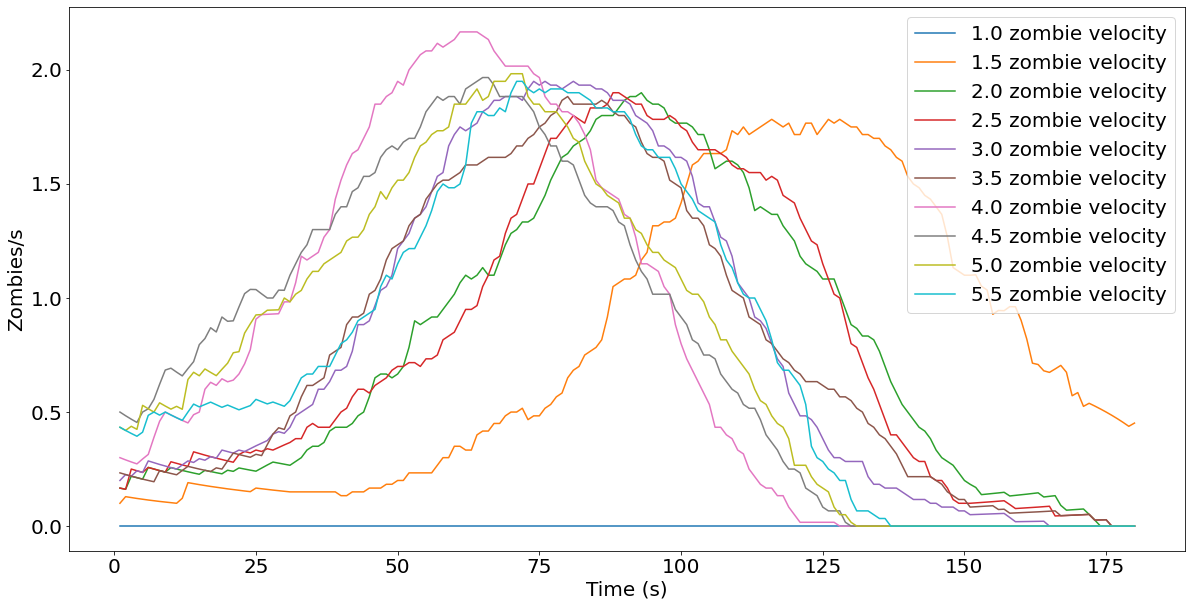

In [80]:
w=60/1
iter = 1
for v in vz:
    y = rolling_mean(np.diff(results_c[v][iter]["zcount"],prepend=1),w)
    dt = results_c[v][iter]["time"][1] - results_c[v][iter]["time"][0]
    y = np.array(y)/dt
    plt.plot(results_c[v][iter]["time"], y, label=f"{v} zombie velocity")
plt.legend()
plt.ylabel("Zombies/s")
plt.xlabel("Time (s)")
plt.show()


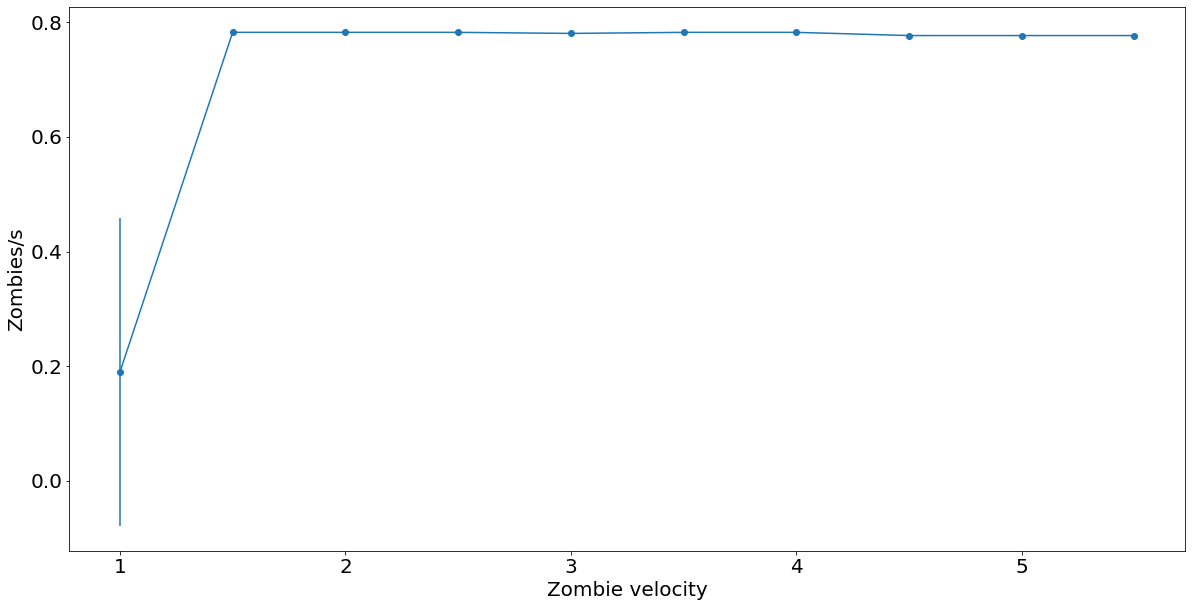

In [81]:
means = []
errors = []
for v in vz:
    values = []
    for iteration in range(iterations):
        delta = results_c[v][iteration]["time"][1]-results_c[v][iteration]["time"][0]
        dif =np.diff(results_c[v][iteration]["zcount"])/delta
        #dif = rolling_mean(dif,1/delta)
        values.append(np.mean(dif))
    means.append(np.mean(values))
    errors.append(np.std(values))
plt.errorbar(vz, means, yerr=errors, fmt="o-")
plt.xlabel("Zombie velocity")
plt.ylabel("Zombies/s")
plt.show()

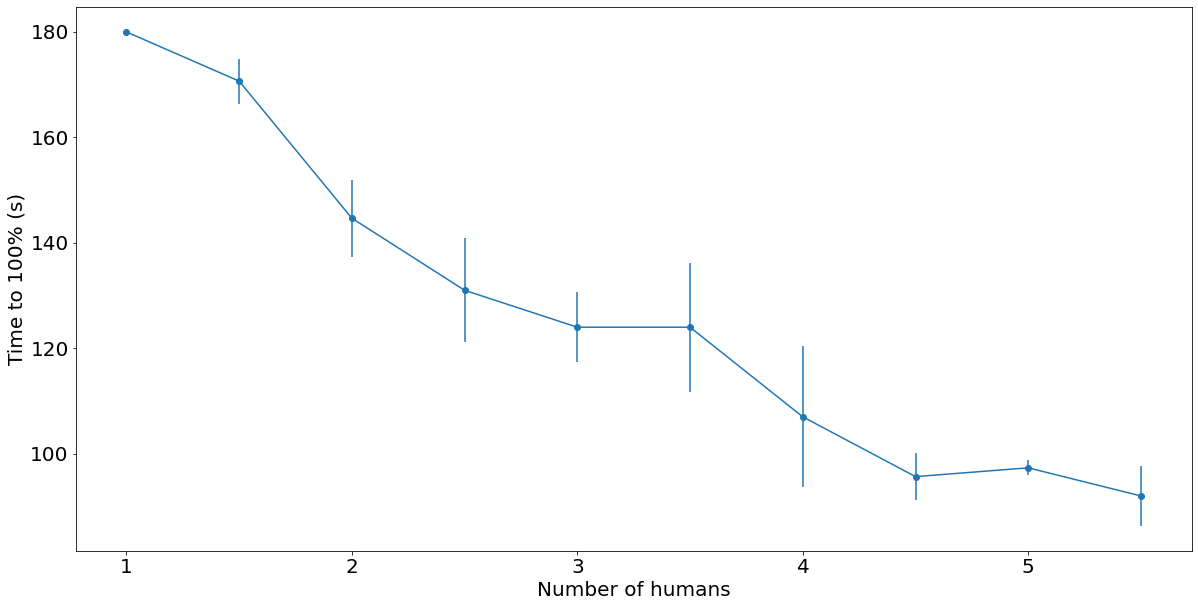

In [82]:
means = []
errors = []
percentage = 100
for v in vz:
    values = []
    for iteration in range(iterations):
        time = 0
        count = results_c[v][iteration]["zcount"]
        times = results_c[v][iteration]["time"]
        for t, z in zip(times,count):
            if z/NH > percentage/100:
                time = t
                break
        
        values.append(t)
    means.append(np.mean(values))
    errors.append(np.std(values)/np.sqrt(len(values)))
plt.errorbar(vz, means, yerr=errors, fmt="o-")
plt.xlabel("Number of humans")
plt.ylabel(f"Time to {percentage}% (s)")
plt.show()

In [83]:
pickle.dump(results_c, open("results_c.pickle", "wb"))